In [1]:
using Pkg,Statistics,Random,Printf,GZip,Knet,Plots,LinearAlgebra,Distributions,StatsBase, Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1640573609760905843\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-15255418586732145572\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/6cbf0fd219fa6416ec9b47399ab16ea685b891e3-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-1640573609760905843\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

## Generate training data

In [2]:
Random.seed!(4);
Range=3.0; # range of the x values for the target Gaussian function
Incr = 0.03; # Number of training examples = 3.0/0.03 = 100
Noise_std=0.1; # add noise on the Gaussian function

In [3]:
# generate the data from which we'll learn the Gaussian function
# obligatory arguments listed before ";" while optional arguments come after ";".
function gen_noisy_gaussian(;range=1.0,noise=0.1)
    x = collect(-Range:Incr:Range)
    y = exp.(-x.^2) + randn(length(x))*noise; # additive gaussian noise
    return (x,y)
end
# output is two vectors x,y

gen_noisy_gaussian (generic function with 1 method)

In [4]:
(x_train,y_train) = gen_noisy_gaussian(range=Range,noise=Noise_std);
pop!(x_train);pop!(y_train);

In [5]:
Ntrain =length(x_train) # number of training data points

200

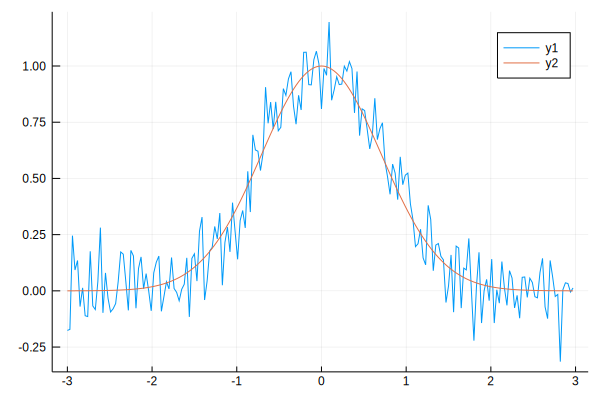

In [6]:
plot(x_train,[y_train,exp.(-x_train.^2)])

## Network + loss function

In [7]:
Batchsize = 10; # determines the degree of batch noise (smaller batchsize => larger noise)
RegWeight=0.001; # lambda for L2 regularization - sets the minimum of the Hessian eigenvalues
InitNorm = 0.5; # initial weight norm - not critical

In [8]:
Nweights = 7

7

In [9]:
function predict(w,x) # returns a row of predicted values for each sample in x
    return w[5:6]'*tanh.(w[1:2]*x' .+ w[3:4]) .+ w[7]
end

predict (generic function with 1 method)

In [10]:
# both x and y are ordered in columns per training data point
function sqloss(w,x,y)
    return mean(abs2,y'-predict(w,x))
end

function reg(w)
    return RegWeight*norm(w)^2
end

function loss(w,x,y)
    return sqloss(w,x,y) + reg(w)
end

loss (generic function with 1 method)

## Gradient

In [11]:
# grad() is a "functional" whose input and output is a function (loss). 
# The output function takes the same arguments as the input function.
# Requires input to be a scalar function and evaluates the gradient wrt elements of the first argument.
# Let ∇f = grad(f). f = f(x,y,z) => ∇f(x,y,z) = ∇ₓf with identical structure as x
lossgradient = grad(loss)
sqlossgradient = grad(sqloss)
reggradient = grad(reg)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(reg),Int64,Bool}}) (generic function with 1 method)

In [12]:
# calculate gradient at the initial w
# dw has dimensions of w: each weight wᵢ is replaced with the ∂/∂wᵢ
@show w = randn(Nweights)
dw = lossgradient(w,x_train,y_train)

w = randn(Nweights) = [0.504805, 0.532632, 0.281184, -0.333792, 2.80494, 0.147718, -0.882034]


7-element Array{Float64,1}:
  7.848550098894413  
  0.29795664798000243
 -4.059705674914736  
 -0.04816032359271255
  1.9653841432168029 
  2.573345280474825  
 -1.5053458677571874 

## Training function (with replacement)

In [13]:
function batchtrain!(w,lr)
perm = randperm(Ntrain)[1:Batchsize]; # a random permutation of [1:Ntrain] - pick batches as chunks from this array        # construct batch
x = [x_train[n] for n in perm]
y = [y_train[n] for n in perm]
# calculate gradient over the batch
dw = lossgradient(w,x,y);
#update weights
    w .-= lr*dw # "." does broadcasting. `this is the same as for i=1:Nweights w[i] -= lr*dw[i] end
return w
end

batchtrain! (generic function with 1 method)

## Initial training run

In [14]:
Random.seed!(2);
w = rand(Nweights); w/= norm(w)/InitNorm
Nmarkov = 50000; # For a quick training run
η = 0.001; # Learning rate

In [15]:
# Initial run - trajectory stored in w_training
w_training = zeros(Nweights,Nmarkov)
time0 = time()
for n = 1:Nmarkov
    w_training[:,n] = batchtrain!(w,η)
end
time()-time0

12.21969485282898

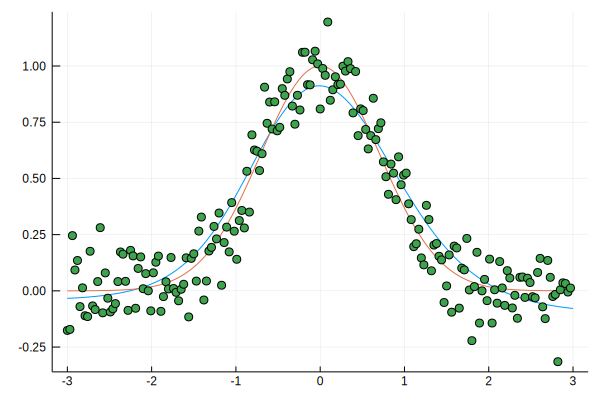

In [16]:
# Checking if the training worked. Compare the learned function with the actual gaussian
xplot=collect(-Range:0.01:Range)
# plot the converged function, the initial gaussian and the noisy training samples
plot(xplot,[predict(w,xplot)',exp.(-xplot.^2)]);
scatter!(x_train,y_train,leg=false)

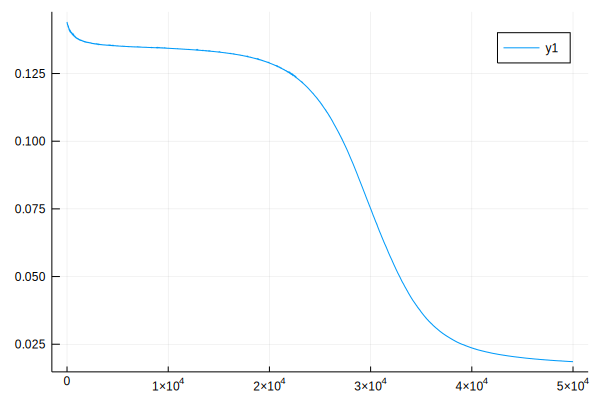

In [17]:
# Plot loss
SamplingRate=min(1,div(Nmarkov,1000));
x = collect(1:SamplingRate:Nmarkov);
y = [loss(w_training[:,i],x_train,y_train) for i in x];
#plot(x,y)
plot(x,y
#    ,xaxis=:log10
#    ,yaxis=:log10
    ) # can also plot in log-log scale

## Diffusion, Hessian, Covariance Matrices

In [18]:
function diffusionmatrix(w,xt,yt,Nb,lr) # Nb = batch size
    Nweights = length(w) # number of weights, that is, dimensions of the diffusion tensor
    Nt = length(xt) # number of training examples to be summed over
    prefac = (Nt-Nb)/(2*Nb*(Nt-1))
    V = zeros(Nweights,Nt) # initialize the diffusion matrix
    for i=1:Nt
        x=xt[i]
        y=yt[i]
        V[:,i] = lossgradient(w,[x],[y])
    end
    V /= Nt;
    dL = sqlossgradient(w,xt,yt);
    
    return lr^2 * prefac * (Nt*V*V' - dL*dL')
end

diffusionmatrix (generic function with 1 method)

In [19]:
# Calculate the diffusion tensor by sampling the noise
function diffusionmatrix_num(w,n,lr) # n: number of samples used for estimation
    wlist = zeros(Nweights,n)
    
    for i=1:n
        ww = copy(w)       
        wlist[:,i] = batchtrain!(ww,lr)
    end

    # subtract mean
    wlist .-= sum(wlist[:,i] for i=1:n)/n

    D = zeros(Nweights,Nweights)
    for α=1:Nweights
        for β=1:Nweights
            for i=1:n
                D[α,β] += wlist[α,i]*wlist[β,i]
            end
            D[α,β] /= n;
        end
    end
    return 0.5*D
end

diffusionmatrix_num (generic function with 1 method)

In [20]:
# To calculate the Hessian, define a scalar function returning ∂L/∂wⱼ
function lossgradj(w,x,y,j)
    return lossgradient(w,x,y)[j]
end

lossgradj (generic function with 1 method)

In [21]:
# Define the function returning ∂²L/∂wᵢ∂wⱼ for all i, given j (a column of the Hessian)
lossgradgrad = grad(lossgradj)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(lossgradj),Int64,Bool}}) (generic function with 1 method)

In [22]:
function hessianmatrix(w,x,y)
    Nw = length(w);
    Hess = zeros(Nw,Nw);
    for j=1:Nw
        Hess[:,j] = lossgradgrad(w,x,y,j)
    end
    return Hess
end

hessianmatrix (generic function with 1 method)

In [23]:
# This calculation is from Michael's overleaf notes:
# https://www.overleaf.com/2523873322bvvnxpwnskfk
function covariancematrix(D,H,lr) # is a function of the learning rate
    F = eigen(H);
    h = F.values
    O = F.vectors
    Nw = length(h)
    ODO = O'*D*O;
    Delta = zeros(Nw,Nw);
    for i=1:Nw
        for j=1:Nw
            Delta[i,j] = ODO[i,j]/(h[i]+h[j])
        end
    end
    return (2/lr)*O*Delta*O'
end

covariancematrix (generic function with 1 method)

### Use Newton's Method to find the minimum of loss

In [24]:
# Using Newton's method get the the true minimum of the full loss function
w = w_training[:,end];
# implement Newton's method to find the true minimum. 4 steps are enough!
for n=1:10
    Hess = hessianmatrix(w,x_train,y_train)
    gradw = lossgradient(w,x_train,y_train)
    dw = inv(Hess)*gradw
    for i=1:Nweights
        w[i] -= dw[i]
    end
end
wmin = w[:,1]

7-element Array{Float64,1}:
 -1.122637781963454  
  1.2309808003009548 
  0.6237242066102502 
  0.6636374755671667 
  0.9024106741830753 
  0.8857884398284765 
 -0.02678967821091649

In [25]:
lossgradient(wmin,x_train,y_train)

7-element Array{Float64,1}:
 -3.599551212651875e-17 
 -2.0383000842727483e-17
 -1.7780915628762273e-17
  2.8406096919120216e-17
  8.998878031629687e-17 
 -8.521829075736065e-17 
  7.135405547670226e-18 

### Hessian at the loss minimum

In [26]:
Hessmin = hessianmatrix(wmin,x_train,y_train)

7×7 Array{Float64,2}:
  0.191185     0.0477188    0.184902    -0.00575416   -0.227777    0.349034      0.290515
  0.0477188    0.152251    -0.00575416  -0.159513     -0.288382    0.188115     -0.255211
  0.184902    -0.00575416   0.329763     0.161818      0.0007127   0.375311      0.533429
 -0.00575416  -0.159513     0.161818     0.291827      0.336862   -0.000504538   0.47856 
 -0.227777    -0.288382     0.0007127    0.336862      1.41088    -1.15104       0.379223
  0.349034     0.188115     0.375311    -0.000504538  -1.15104     1.46174       0.348845
  0.290515    -0.255211     0.533429     0.47856       0.379223    0.348845      2.002   

In [27]:
eigvals(Hessmin), norm(Hessmin)

([2.75878, 2.53553, 0.293597, 0.192422, 0.048197, 0.00595349, 0.00516699], 3.7636935681919423)

### Diffusion tensor at the loss minimum

In [28]:
# diffusion tensor at the loss minimum (using VV')
Dmin = diffusionmatrix(wmin,x_train,y_train,Batchsize,η)

7×7 Array{Float64,2}:
  1.74339e-10   5.32896e-11   1.54906e-10  -1.93927e-11  -2.59239e-10   3.50367e-10   2.68857e-10
  5.32896e-11   1.88831e-10  -1.99704e-11  -2.04497e-10  -3.63366e-10   2.25552e-10  -3.38932e-10
  1.54906e-10  -1.99704e-11   2.74216e-10   1.5485e-10   -2.40275e-13   3.30599e-10   4.98134e-10
 -1.93927e-11  -2.04497e-10   1.5485e-10    3.28789e-10   4.0503e-10   -5.15288e-11   5.37777e-10
 -2.59239e-10  -3.63366e-10  -2.40275e-13   4.0503e-10    1.65058e-9   -1.35824e-9    5.82879e-10
  3.50367e-10   2.25552e-10   3.30599e-10  -5.15288e-11  -1.35824e-9    1.59548e-9    1.39242e-10
  2.68857e-10  -3.38932e-10   4.98134e-10   5.37777e-10   5.82879e-10   1.39242e-10   2.20289e-9 

In [29]:
# compare with D calculated numerically
Dmin_num = diffusionmatrix_num(wmin,10000,η);
Dmin_num ./ Dmin

7×7 Array{Float64,2}:
 0.992992  0.949563    1.00709  0.835258    0.96222   0.981118  1.02502 
 0.949563  0.979003    1.0152   0.97751     0.98591   0.991195  0.970264
 1.00709   1.0152      1.02529  1.03055   -37.5768    1.00185   1.00698 
 0.835258  0.97751     1.03055  0.994277    0.998312  0.924281  0.981677
 0.96222   0.98591   -37.5768   0.998312    0.993597  0.987467  0.995389
 0.981118  0.991195    1.00185  0.924281    0.987467  0.992658  0.990885
 1.02502   0.970264    1.00698  0.981677    0.995389  0.990885  0.990291

In [30]:
@show isapprox(Dmin_num,Dmin, rtol=0.01)
@show isapprox(Dmin_num,Dmin, rtol=0.02)

isapprox(Dmin_num, Dmin, rtol=0.01) = false
isapprox(Dmin_num, Dmin, rtol=0.02) = true


true

### Covariance matrix as a function of Hessian and Diffusion matrix

In [31]:
Covmin = covariancematrix(Dmin,Hessmin,η)

7×7 Array{Float64,2}:
  7.17113e-7   1.76395e-8   9.69501e-8  -4.36648e-8  -1.24584e-7  -7.20727e-8   5.16229e-8
  1.76395e-8   9.53257e-7  -2.00778e-8  -2.7168e-7    5.30452e-8   6.42348e-8  -1.02505e-8
  9.69501e-8  -2.00778e-8   5.90928e-7  -8.52919e-8   2.04093e-7   2.09795e-7  -7.07494e-9
 -4.36648e-8  -2.7168e-7   -8.52919e-8   7.84851e-7   2.27483e-7   2.28712e-7  -1.36924e-8
 -1.24584e-7   5.30452e-8   2.04093e-7   2.27483e-7   8.12191e-7  -3.33188e-7   8.25478e-8
 -7.20727e-8   6.42348e-8   2.09795e-7   2.28712e-7  -3.33188e-7   8.09326e-7  -1.04931e-7
  5.16229e-8  -1.02505e-8  -7.07494e-9  -1.36924e-8   8.25478e-8  -1.04931e-7   1.09935e-6

In [32]:
# verify that the math is right: HC+CH = (2/η)D
norm(Hessmin*Covmin + Covmin*Hessmin - (2/η)*Dmin) # should be zero

1.8530879034325598e-20

### Derivative of the diffusion tensor

In [33]:
# construct a scalar function returning each element of the loss gradient
# sqloss is the loss without the regularization part.
function sqlossgradj(w,x,y,j)
    return sqlossgradient(w,x,y)[j]
end

sqlossgradj (generic function with 1 method)

In [34]:
# returns ∇(∂L/∂wⱼ)
sqlossgradgrad = grad(sqlossgradj)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(sqlossgradj),Int64,Bool}}) (generic function with 1 method)

In [35]:
# Calculate ∇D. ∇D[i,j,k] ≡ ∂D[j,k]/∂wᵢ

function gradkdiffij(w,xt,yt,Nb,lr)
    Nweights = length(w) 
    Nt = length(xt) # number of training examples to be summed over
    prefac = (Nt-Nb)/(2*Nb*(Nt-1))
    ∇D = zeros(Nweights,Nweights,Nweights)
    dL = sqlossgradient(w,xt,yt)
    ddL = hessianmatrix(w,xt,yt) - 2*RegWeight*diagm(0=>ones(Nweights)) # nly sqloss()'s 2nd derivative
    for n=1:Nt
        x=xt[n]
        y=yt[n]
        
        dLn = sqlossgradient(w,[x],[y])
        
        ddLn = zeros(Nweights,Nweights);
        for i=1:Nweights
            ddLn[:,i] = sqlossgradgrad(w,[x],[y],i)
        end
        
        for i=1:Nweights
            for j=1:Nweights
                ∇D[:,i,j] += ddLn[:,i]*dLn[j] + ddLn[:,j]*dLn[i]
            end
        end
    end
    ∇D /= Nt
    
    for i=1:Nweights
        for j=1:Nweights
            ∇D[:,i,j] -= ddL[:,i]*dL[j] + dL[i]*ddL[:,j]
        end
    end

    return lr^2 * prefac * ∇D
end

gradkdiffij (generic function with 1 method)

In [36]:
# Calculate ∇D using finite difference for validation
function gradkdiffij_num(w,xt,yt,Nb,lr;eps=1e-5)
    Nw = length(w) 
    D = diffusionmatrix(w,xt,yt,Nb,lr);
    dD = zeros(Nw,Nw,Nw);
    for i=1:Nw
        dw = zeros(Nw);
        dw[i] += eps
        dD[i,:,:] = diffusionmatrix(w+dw,xt,yt,Nb,lr)-diffusionmatrix(w-dw,xt,yt,Nb,lr);
    end
    dD /= 2*eps
    
    return dD
end

gradkdiffij_num (generic function with 1 method)

In [37]:
# Calculate ∇[inv(D)] using finite difference for validation
function gradkinvdiffij_num(w,xt,yt,Nb,lr;eps=1e-8)
    Nw = length(w) 
    dDinv = zeros(Nw,Nw,Nw);
    for i=1:Nw
        dw = zeros(Nw);
        dw[i] += eps
        dDinv[i,:,:] = inv(diffusionmatrix(w+dw,xt,yt,Nb,lr))-inv(diffusionmatrix(w-dw,xt,yt,Nb,lr));
    end
    dDinv /= 2*eps
    
    return dDinv
end

gradkinvdiffij_num (generic function with 1 method)

In [38]:
Random.seed!(5)
w = randn(Nweights)
@time ∇D = gradkdiffij(w,x_train,y_train,Batchsize,η);

  3.140644 seconds (2.67 M allocations: 140.771 MiB, 3.56% gc time)


norm(∇D - ∇D_num) / norm(∇D) = 0.0013823398482378988


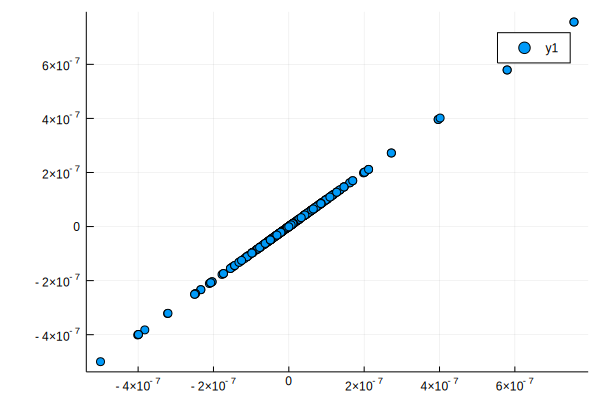

In [39]:
∇D_num = gradkdiffij_num(w,x_train,y_train,Batchsize,η,eps=1e-6);
@show norm(∇D-∇D_num)/norm(∇D)
scatter(reshape(∇D,Nweights^3,1),reshape(∇D_num,Nweights^3,1))

In [40]:
D = diffusionmatrix(w,x_train,y_train,Batchsize,η)
invD = inv(D)
∇invD = zeros(Nweights,Nweights,Nweights)
for n=1:Nweights
    ∇invD[n,:,:] = -invD*∇D_num[n,:,:]*invD # = ∂D⁻¹/∂w_n # this works
#    ∇invD[n,:,:] = -invD*∇D[n,:,:]*invD # = ∂D⁻¹/∂w_n # this doesn't, although ∇D and ∇D_num agree to within 0.1%
end
∇invD_num = gradkinvdiffij_num(w,x_train,y_train,Batchsize,η,eps=1e-8);
norm(∇invD-∇invD_num)/norm(∇invD)

0.03698272528316345

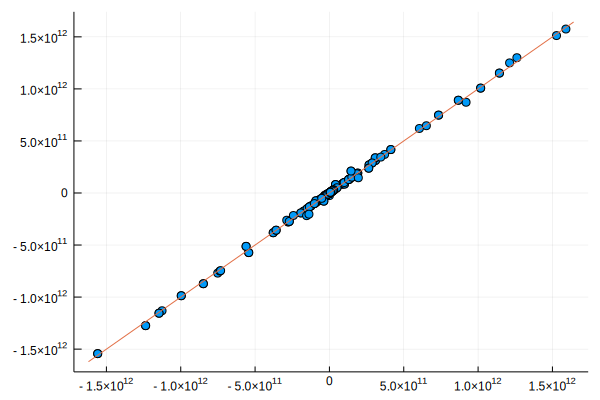

In [41]:
# What is the problem with ∇invD[n,:,:] = -invD*∇D[n,:,:]*invD in the previous cell?
scatter(reshape(∇invD,Nweights^3,1),reshape(∇invD_num,Nweights^3,1))
g(x)=x
plot!(g,leg=false)

In [42]:
eigD = eigvals(Dmin/η^2)

7-element Array{Float64,1}:
 0.0033283735879252267 
 0.00255016154612881   
 0.0003138688521341561 
 0.00017864308486948444
 4.0403455659777284e-5 
 3.525140803148801e-6  
 1.4098105369783783e-7 

In [43]:
count(x -> (x > 1e-10),eigvals(Dmin))

4

## Thermal SGD - with C = lr\*T\*inv(Dmin)

In [44]:
function thermaltrain!(w,lr,T)
    perm = randperm(Ntrain)[1:Batchsize]; # a random permutation of [1:Ntrain] - pick batches as chunks from this array        # construct batch
    x = [x_train[n] for n in perm]
    y = [y_train[n] for n in perm]
# gradient calculated on the batch
    gradw = lossgradient(w,x,y)
# calculate C
    D = Symmetric(diffusionmatrix(w,x_train,y_train,Batchsize,lr))
    k = count(x -> (x > 1e-6),eigvals(D/η^2)) # pick eigenvalues greater than 1e-10
    ef = eigen(D, Nweights-k+1:Nweights) #k largest eigenvalues/vectors
    Λ = reverse(ef.values, dims=1) # kxk matrix of top k eigenvalues in descending order
    U = reverse(ef.vectors,dims=2) # 7 x k matrix
    C = lr*T*U*Diagonal(1.0./Λ)*U'
# update w
    dw = C*gradw # + q
    for i=1:length(w)
        w[i] -= lr*dw[i]
    end

    return w
end

thermaltrain! (generic function with 1 method)

## Thermal learning

In [45]:
Random.seed!(2) # Verified that the results don't change for different seeds.
w = rand(Nweights); w/= norm(w)/InitNorm;
w_init = copy(w)
D_init = diffusionmatrix(w,x_train,y_train,Batchsize,η); eigvals(D_init)

7-element Array{Float64,1}:
  3.296450930207049e-8  
  2.7468045693074525e-9 
  1.2225337308454564e-11
  6.453996093280313e-13 
  8.958209191634505e-15 
  6.998436026068111e-18 
 -1.425957748570444e-15 

In [46]:
Nmarkov=5*10^4

50000

In [47]:
mult_max=13
w_ss = zeros(mult_max,Nweights,Nmarkov)
xlims = Nmarkov*ones(Int,mult_max)
for mult=1:mult_max
    w = copy(w_init)
    Temp = (2^mult)*1e-7
    @show mult,Temp
    n=1
    w_ss[mult,:,n] = copy(w)
    los=1.0
    while(n<Nmarkov && los>0.018)
        n += 1
        w_ss[mult,:,n] = thermaltrain!(w,η,Temp)
        if (n%100==1)
            los = loss(w,x_train,y_train)
            @show n,los
        end
    end
    xlims[mult]=n
end

(mult, Temp) = (1, 2.0e-7)
(n, los) = (101, 0.1436889419601611)
(n, los) = (201, 0.14337541644274146)
(n, los) = (301, 0.14306126407082795)
(n, los) = (401, 0.14270701523565202)
(n, los) = (501, 0.14232164491377094)
(n, los) = (601, 0.14195146838936282)
(n, los) = (701, 0.14154973658049755)
(n, los) = (801, 0.14118236288621688)
(n, los) = (901, 0.140790039624966)
(n, los) = (1001, 0.14042542409500985)
(n, los) = (1101, 0.14003651198474645)
(n, los) = (1201, 0.1396453395405404)
(n, los) = (1301, 0.13926908910815494)
(n, los) = (1401, 0.13887321195129881)
(n, los) = (1501, 0.13848045753999255)
(n, los) = (1601, 0.1380771387427449)
(n, los) = (1701, 0.13769215988069855)
(n, los) = (1801, 0.13730194962730247)
(n, los) = (1901, 0.13692810572576333)
(n, los) = (2001, 0.1365598835298563)
(n, los) = (2101, 0.13619131359535394)
(n, los) = (2201, 0.1358014341727358)
(n, los) = (2301, 0.13542496166902304)
(n, los) = (2401, 0.13503589762282414)
(n, los) = (2501, 0.13467983200484487)
(n, los) = (26

(n, los) = (23001, 0.07048323120700399)
(n, los) = (23101, 0.07031362808103832)
(n, los) = (23201, 0.07015307113490904)
(n, los) = (23301, 0.06998422307731933)
(n, los) = (23401, 0.06981100266290302)
(n, los) = (23501, 0.06964972813500203)
(n, los) = (23601, 0.06947654431171046)
(n, los) = (23701, 0.06931412820582353)
(n, los) = (23801, 0.06914288486658682)
(n, los) = (23901, 0.0689910887623947)
(n, los) = (24001, 0.06882637425835182)
(n, los) = (24101, 0.06866370288802455)
(n, los) = (24201, 0.06850790176825355)
(n, los) = (24301, 0.06835587062013689)
(n, los) = (24401, 0.06819530386355367)
(n, los) = (24501, 0.06803829922324896)
(n, los) = (24601, 0.0679015059144398)
(n, los) = (24701, 0.06775324295569222)
(n, los) = (24801, 0.06760303403665499)
(n, los) = (24901, 0.06744624863023262)
(n, los) = (25001, 0.06730841295408761)
(n, los) = (25101, 0.06716441852018362)
(n, los) = (25201, 0.06700489247328228)
(n, los) = (25301, 0.06685515586937023)
(n, los) = (25401, 0.06671256953690104)
(n

(n, los) = (46301, 0.04042295684023098)
(n, los) = (46401, 0.04031994889050044)
(n, los) = (46501, 0.04020257602179362)
(n, los) = (46601, 0.0400844878970291)
(n, los) = (46701, 0.0399679657414617)
(n, los) = (46801, 0.039857515185560036)
(n, los) = (46901, 0.03973881785082727)
(n, los) = (47001, 0.03962588484115169)
(n, los) = (47101, 0.03950492458938983)
(n, los) = (47201, 0.03938827032019113)
(n, los) = (47301, 0.03926746206944796)
(n, los) = (47401, 0.03914566893959752)
(n, los) = (47501, 0.03903322473355705)
(n, los) = (47601, 0.03890426993465431)
(n, los) = (47701, 0.03878817052143001)
(n, los) = (47801, 0.038685742650918314)
(n, los) = (47901, 0.038571520247519406)
(n, los) = (48001, 0.038460924395845135)
(n, los) = (48101, 0.038341302051385424)
(n, los) = (48201, 0.038224400942562485)
(n, los) = (48301, 0.0381186524238862)
(n, los) = (48401, 0.038008044700731)
(n, los) = (48501, 0.03790951023584273)
(n, los) = (48601, 0.037789718523259005)
(n, los) = (48701, 0.03767120953563532

(n, los) = (10401, 0.04609199340028891)
(n, los) = (10501, 0.045581436754681896)
(n, los) = (10601, 0.0450584272732408)
(n, los) = (10701, 0.044564427515968626)
(n, los) = (10801, 0.044080287547342334)
(n, los) = (10901, 0.04364955851534108)
(n, los) = (11001, 0.04316293152988876)
(n, los) = (11101, 0.04264624949982275)
(n, los) = (11201, 0.04221048352487811)
(n, los) = (11301, 0.0417353706694975)
(n, los) = (11401, 0.041294430967631225)
(n, los) = (11501, 0.040835606139293434)
(n, los) = (11601, 0.040361944282114204)
(n, los) = (11701, 0.03988697729320372)
(n, los) = (11801, 0.039428963215606246)
(n, los) = (11901, 0.03898048402687083)
(n, los) = (12001, 0.03851485877533072)
(n, los) = (12101, 0.038082706576697475)
(n, los) = (12201, 0.03762163179358243)
(n, los) = (12301, 0.03714550073993401)
(n, los) = (12401, 0.03665390557720358)
(n, los) = (12501, 0.03620591779868525)
(n, los) = (12601, 0.035774197943383684)
(n, los) = (12701, 0.0353377738934717)
(n, los) = (12801, 0.0348727649069

(n, los) = (4201, 0.019942150129420348)
(n, los) = (4301, 0.01909269469933994)
(n, los) = (4401, 0.018442208095927618)
(n, los) = (4501, 0.017761459877801363)
(mult, Temp) = (6, 6.4e-6)
(n, los) = (101, 0.13229253336666727)
(n, los) = (201, 0.11966400361079285)
(n, los) = (301, 0.10901661505436168)
(n, los) = (401, 0.09762473713770593)
(n, los) = (501, 0.0874046115297179)
(n, los) = (601, 0.07830992412388844)
(n, los) = (701, 0.0716794448741246)
(n, los) = (801, 0.06664771714586955)
(n, los) = (901, 0.062116054509251235)
(n, los) = (1001, 0.05817959303975215)
(n, los) = (1101, 0.05428579673869726)
(n, los) = (1201, 0.050522660389196596)
(n, los) = (1301, 0.046763109221013364)
(n, los) = (1401, 0.042976656665735795)
(n, los) = (1501, 0.039812459021937405)
(n, los) = (1601, 0.03650448774976532)
(n, los) = (1701, 0.03316954491235498)
(n, los) = (1801, 0.030047305628212513)
(n, los) = (1901, 0.026960901583026366)
(n, los) = (2001, 0.024214958839669284)
(n, los) = (2101, 0.02153351856018933

(n, los) = (14301, 1.5521348796861874)
(n, los) = (14401, 0.2722728306344016)
(n, los) = (14501, 0.4975186778307191)
(n, los) = (14601, 0.11016870551608281)
(n, los) = (14701, 0.413388579594549)
(n, los) = (14801, 0.2142730634905114)
(n, los) = (14901, 4459.849513171118)
(n, los) = (15001, 4379.909128210266)
(n, los) = (15101, 4357.313763701348)
(n, los) = (15201, 4348.839226171844)
(n, los) = (15301, 4344.895745069159)
(n, los) = (15401, 4343.338306712778)
(n, los) = (15501, 4341.613143169928)
(n, los) = (15601, 4339.8918617553145)
(n, los) = (15701, 4338.188156570957)
(n, los) = (15801, 4337.320081153373)
(n, los) = (15901, 4336.697662297513)
(n, los) = (16001, 4336.185041246978)
(n, los) = (16101, 4335.695656913051)
(n, los) = (16201, 4335.158500495625)
(n, los) = (16301, 4334.70071661961)
(n, los) = (16401, 4334.229638950302)
(n, los) = (16501, 4333.778173324832)
(n, los) = (16601, 4333.337772063993)
(n, los) = (16701, 4332.898604329769)
(n, los) = (16801, 4332.352903958367)
(n, lo

(n, los) = (35701, 19656.81688741487)
(n, los) = (35801, 19647.6358301214)
(n, los) = (35901, 19638.378554954594)
(n, los) = (36001, 19629.115416034223)
(n, los) = (36101, 19619.847674365952)
(n, los) = (36201, 19610.73569567925)
(n, los) = (36301, 19601.577592223333)
(n, los) = (36401, 19592.204779226522)
(n, los) = (36501, 19583.02179661055)
(n, los) = (36601, 19573.812145595228)
(n, los) = (36701, 19564.62121304393)
(n, los) = (36801, 19555.31982823599)
(n, los) = (36901, 19545.987375806777)
(n, los) = (37001, 19536.98999065895)
(n, los) = (37101, 19527.75012327997)
(38901, 19362.486302465033)
(n, los) = (39001, 19353.251617959693)
(n, los) = (39101, 19344.20467625299)
(n, los) = (39201, 19335.12735763189)
(n, los) = (39301, 19325.988005345967)
(n, los) = (39401, 19317.133331503734)
(n, los) = (39501, 19307.74740887088)
(n, los) = (39601, 19298.62282389936)
(n, los) = (39701, 19289.830239836923)
(n, los) = (39801, 19280.786540781923)
(n, los) = (39901, 19271.735795014574)
(n, los) =

In [51]:
# Plot loss
# SGD loss
sr=10
Ntraining = length(w_training[1,:])
y_sgd = [loss(w_training[:,i],x_train,y_train) for i=1:sr:Ntraining];
myplot = plot(collect(1:sr:Ntraining),y_sgd) # can also plot in log-log scale

# Thermal loss
for mult=1:mult_max-3
    x = collect(1:xlims[mult])
    y = [loss(w_ss[mult,:,i],x_train,y_train) for i in x];
    myplot = plot!(x,y
        ,xlim=[1,Nmarkov]
        ,ylim=[0,0.2]
        ,xaxis=:log
        ,leg=false)
end
myplot